## 3.2 现代卷积神经网络
现代卷积神经网络的研究中下面每一个模型都曾一度占据主导地位，其中许多模型都是ImageNet竞赛的优胜者。ImageNet竞赛自2010年以来，一直是计算机视觉中**监督学习**进展的指向标。其包括:
* LeNet: 最”远古“的神经网络。
* AlexNet。它是第一个在大规模视觉竞赛中击败传统计算机视觉模型的大型神经网络。
* 使用重复块的网络（VGG）。它利用许多重复的神经网络块。
* 网络中的网络（NiN）。它重复使用由卷积层和$1 \times 1$卷积层（用来代替全连接层）来构建深层网络。
* 含并行连结的网络（GoogLeNet）。它使用并行连结的网络，通过不同窗口大小的卷积层和最大池化层来并行抽取信息。
* 残差网络（ResNet）。它通过残差块构建跨层的数据通道，是计算机视觉中最流行的体系架构。
* 稠密连接网络（DenseNet）。它的计算成本很高，但给我们带来了更好的效果。

*温馨提示: 本小节内容较多，读者可根据自己需要来进行阅读。*

### 3.2.1 LeNet
这个模型是由AT&T贝尔实验室的研究员Yann LeCun在1989年提出的（并以其命名），目的是识别图像中的手写数字。 当时，Yann LeCun发表了第一篇通过反向传播成功训练卷积神经网络的研究，这项工作代表了十多年来神经网络研究开发的成果。
当时，LeNet取得了与支持向量机（support vector machines）性能相媲美的成果，成为监督学习的主流方法。 LeNet被广泛用于自动取款机（ATM）机中，帮助识别处理支票的数字。 时至今日，一些自动取款机仍在运行Yann LeCun和他的同事Leon Bottou在上世纪90年代写的代码。

总体来看，LeNet（LeNet-5）由两个部分组成：
* 卷积编码器：由**两个卷积层**组成
* 全连接层密集块：由**三个全连接层**组成

每个卷积块中的基本单元是一个卷积层、一个sigmoid激活函数和平均池化层。请注意，虽然ReLU和最大池化层更有效，但它们在20世纪90年代还没有出现。每个卷积层使用$5 \times 5$卷积核和一个sigmoid激活函数。这些层将输入映射到多个二维特征输出，通常同时增加通道的数量。第一卷积层有6个输出通道，而第二个卷积层有16个输出通道。每个$2 \times 2$池操作（步骤2）通过空间下采样将维数减少4倍。卷积的输出形状由批量大小、通道数、高度、宽度决定。如下图所示:
![](https://zh-v2.d2l.ai/_images/lenet.svg)

为了将卷积块的输出传递给稠密块，我们必须在小批量中展平每个样本。换言之，我们将这个四维输入转换成全连接层所期望的二维输入。这里的二维表示的第一个维度索引小批量中的样本，第二个维度给出每个样本的平面向量表示。LeNet的稠密块有三个全连接层，分别有120、84和10个输出。因为我们在执行分类任务，所以输出层的10维对应于最后输出结果的数量(识别0-9的数字)。

下面我们通过Pytorch代码，使用一个Sequential块即可把上面所描述的层全部连接起来。

对原始模型做了一点小改动，去掉了最后一层的高斯激活。

In [4]:
import torch
from torch import nn

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

下面，我们将一个大小为$28 \times 28$的单通道（黑白）图像通过LeNet。通过在每一层打印输出的形状，我们可以检查模型是否与下图保持一致:
![](https://zh-v2.d2l.ai/_images/lenet-vert.svg)

In [5]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


#### 训练模型
下面我们通过训练模型进行实战，我们选取Fashion-MNIST数据集
* Fashion-MNIST: 含有非数字的图片
* 原始MNIST: 只含有数字图片

为了演示方便，同样使用d2l库，并且我的本机环境采用CPU进行训练，但是如果有条件，可以尝试GPU来加快训练。
下面代码在GPU与CPU上均可跑通:

* 加载数据集

In [6]:
from d2l import torch as d2l
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



D:\tensorflow1\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


由于完整的数据集位于内存中，因此在模型使用GPU计算数据集之前，我们需要将其复制到显存中。

* 计算模型精度

In [7]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """ 使用GPU计算模型所在数据集的精度"""
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总浏览数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

下面我们开始训练:
我们使用Xavier随机初始化模型参数。 与全连接层一样，我们使用交叉熵损失函数和小批量随机梯度下降。

In [8]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.465, train acc 0.827, test acc 0.828
5740.3 examples/sec on cpu


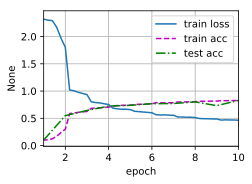

In [9]:
lr, num_epochs = 0.9, 10
train(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())